/home/l/.conda/envs/spacy/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train on 80000 samples, validate on 100000 samples
Epoch 1/50
 - 9s - loss: 0.0220 - val_loss: 0.0112
Epoch 2/50
 - 3s - loss: 0.0130 - val_loss: 0.0101
Epoch 3/50
 - 3s - loss: 0.0121 - val_loss: 0.0092
Epoch 4/50
 - 3s - loss: 0.0114 - val_loss: 0.0085
Epoch 5/50
 - 3s - loss: 0.0108 - val_loss: 0.0079
Epoch 6/50
 - 3s - loss: 0.0102 - val_loss: 0.0074
Epoch 7/50
 - 3s - loss: 0.0097 - val_loss: 0.0070
Epoch 8/50
 - 3s - loss: 0.0092 - val_loss: 0.0066
Epoch 9/50
 - 3s - loss: 0.0087 - val_loss: 0.0062
Epoch 10/50
 - 3s - loss: 0.0081 - val_loss: 0.0059
Epoch 11/50
 - 3s - loss: 0.0073 - val_loss: 0.0056
Epoch 12/50
 - 3s - loss: 0.0065 - val_loss: 0.0055
Epoch 13/50
 - 3s - loss: 0.0056 - val_loss: 0.0054
Epoch 14/50
 - 3s - loss: 0.0049 - val_loss: 0.0053
Epoch 15/50
 - 3s - loss: 0.0043 - val_loss: 0.0051
Epoch 16/50
 - 3s - loss: 0.0038 - val_loss: 0.0048
Epoch 17/50
 - 3s - loss: 0.0033 - val_loss: 0.0044
Epoch 18/50
 - 3s - loss: 0.0029 - val_loss: 0.0039
Epoch 19/50
 - 3s - lo

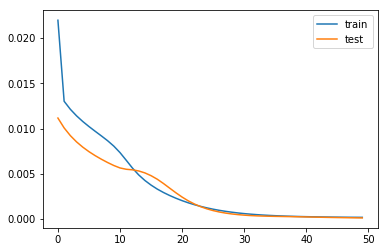

Test RMSE: 0.027
Train/Test size: 80000 / 100000 Epochs: 50 Batch-size: 512 #Features: 20


In [55]:
import numpy as np
from numpy import concatenate
from math import sqrt
import scipy
import scipy.stats as stats
import statsmodels
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os

# DATA 
muse_df = pd.read_csv('Muse_big.csv')
del muse_df["Battery"]
del muse_df["Elements"]
del muse_df["HeadBandOn"]

# DATA CLEANING
muse_df = muse_df.iloc[161:, 1:21] # dropping TimeStamp, no-needed columns, few initial rows
muse_df = muse_df.dropna()
muse_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='') 
muse_df.index += 1 
values = muse_df.values
values = values.astype('float32')


#
#
#
#
#
#
#
#
#

# DATA PREP FOR SUPERVISED LEARNING
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
reframed = series_to_supervised(scaled, 1, 1)

columns_to_stay = []
for i in range(20,40):
    if i not in [36,37,38,39]: 
        columns_to_stay.append(i)
reframed.drop(reframed.columns[columns_to_stay], axis=1, inplace=True)

values = reframed.values


# TRAIN/TEST SPLIT
train_break = 80000
test_break = 180000
train = values[:train_break, :]
test = values[train_break:test_break, :]

train_X, train_y = train[:, :-4], train[:, -1:]
test_X, test_y = test[:, :-4], test[:, -1:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# FIT DATA INTO MODEL
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')

my_epochs = 50
my_batch_size= 16 * 16 * 2

history = model.fit(train_X, train_y, epochs=my_epochs, batch_size=my_batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# PREDICTION
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print("Train/Test size:",train_break,"/",test_break-train_break,"Epochs:",my_epochs, "Batch-size:",my_batch_size,"#Features:", train_X.shape[2])

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 50)                14200     
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 51        
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 2         
Total params: 14,253
Trainable params: 14,253
Non-trainable params: 0
_________________________________________________________________
